In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/multiclass-hierarchical/')

!ls

Mounted at /content/drive
mc_abstain.ipynb


In [2]:
# import utilities
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import data visualization
import matplotlib.pyplot as plt

# import pytorch
import torch
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

In [3]:
# statistics of CIFAR-100 dataset, used for normalising the images
stats = ((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))
train_transform = tt.Compose([
    #tt.RandomHorizontalFlip(),
    #tt.RandomCrop(32,padding=4,padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [4]:
# Get dataset. If not present at ./data, automatically downloads from the web
train_data = CIFAR100(download=True,root="./data",transform=train_transform)
test_data = CIFAR100(root="./data",train=False,transform=test_transform)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


In [12]:
# Define dataloaders
batch_size = 128
trainloader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
testloader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [13]:
train_data.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [14]:
# number of epochs
epochs = 50
# learning rate
learning_rate = 0.001
# device to use
# don't forget to turn on GPU on kernel's settings
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
# use inbuilt architecture, without weights
#model = torchvision.models.densenet121(pretrained=False)
model = torchvision.models.densenet201(pretrained=False)

In [16]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

In [17]:
#train the model
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy']) 

# send to CUDA if possible
model.to(device)

running_loss = 0
for epoch in range(epochs):
    batch_idx = 0
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in trainloader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # calculate train top-1 accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # Calculate train top-3 accuracy
        np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = labels.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
        print('Training Epoch: {epoch} [{trained_samples}/{total_samples}]\tLoss: {:0.4f}\tLR: {:0.6f}'.format(
            loss.item(),
            optimizer.param_groups[0]['lr'],
            epoch=epoch+1,
            trained_samples=batch_idx * batch_size + len(inputs),
            total_samples=len(trainloader.dataset)
        ))
        batch_idx += 1
        
    time_elapsed = time.time() - since
    
    # testing model after this training epoch to get epoch-wise performance
    test_loss = 0
    test_accuracy = 0
    top3_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Calculate test top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
          f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}")

    # store epoch stats
    train_stats = train_stats.append(
            {'Epoch': epoch,
            'Time per epoch':time_elapsed, 
            'Avg time per step': time_elapsed/len(trainloader), 
            'Train loss' : running_loss/len(trainloader), 
            'Train accuracy': train_accuracy/len(trainloader), 
            'Train top-3 accuracy':top3_train_accuracy/len(trainloader), 
            'Test loss' : test_loss/len(testloader), 
            'Test accuracy': test_accuracy/len(testloader), 
            'Test top-3 accuracy':top3_test_accuracy/len(testloader)}, 
            ignore_index=True)

    # save checkpoint
    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss/len(trainloader),
            }, "./models/densenet201_bs_128_chkpt_" + str(epoch+1) +".pt")
    
    running_loss = 0

    model.train()

Streaming output truncated to the last 5000 lines.
Training Epoch: 9 [384/50000]	Loss: 0.6129	LR: 0.001000
Training Epoch: 9 [512/50000]	Loss: 0.5701	LR: 0.001000
Training Epoch: 9 [640/50000]	Loss: 0.9605	LR: 0.001000
Training Epoch: 9 [768/50000]	Loss: 0.8811	LR: 0.001000
Training Epoch: 9 [896/50000]	Loss: 1.1329	LR: 0.001000
Training Epoch: 9 [1024/50000]	Loss: 0.9070	LR: 0.001000
Training Epoch: 9 [1152/50000]	Loss: 0.7078	LR: 0.001000
Training Epoch: 9 [1280/50000]	Loss: 0.8301	LR: 0.001000
Training Epoch: 9 [1408/50000]	Loss: 0.8776	LR: 0.001000
Training Epoch: 9 [1536/50000]	Loss: 0.9397	LR: 0.001000
Training Epoch: 9 [1664/50000]	Loss: 0.9502	LR: 0.001000
Training Epoch: 9 [1792/50000]	Loss: 0.8253	LR: 0.001000
Training Epoch: 9 [1920/50000]	Loss: 0.9328	LR: 0.001000
Training Epoch: 9 [2048/50000]	Loss: 0.7702	LR: 0.001000
Training Epoch: 9 [2176/50000]	Loss: 0.9765	LR: 0.001000
Training Epoch: 9 [2304/50000]	Loss: 0.7877	LR: 0.001000
Training Epoch: 9 [2432/50000]	Loss: 1.096

KeyboardInterrupt: ignored

In [18]:
# save epoch wise stats
train_stats.to_csv('train_log_DenseNet201.csv')

# 1 2 3 4 5 6 13 20

In [ ]:
model = torchvision.models.densenet121()
optimizer = Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load("./models/densenet201_bs_128_chkpt_")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

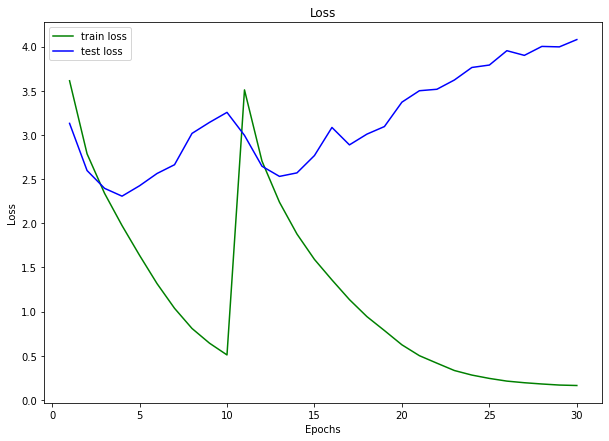

In [19]:
# Plotting Loss curves

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

x = range(1, len(train_stats['Train loss'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-g', label='train loss')
ax.plot(x, train_stats['Test loss'].values, '-b', label='test loss')

plt.legend()

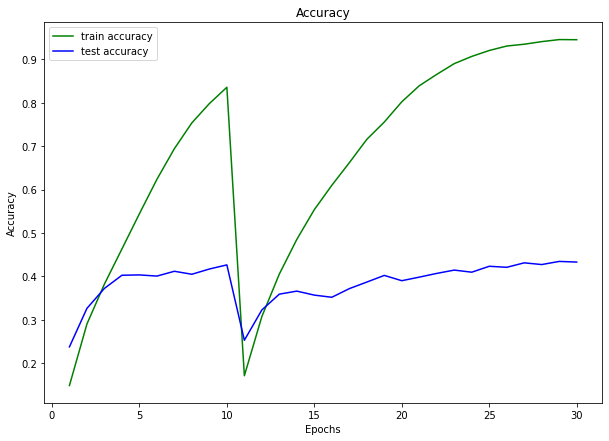

In [20]:
# Plotting Accuracy curves
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

x = range(1, len(train_stats['Train accuracy'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-g', label='train accuracy')
ax.plot(x, train_stats['Test accuracy'].values, '-b', label='test accuracy')

plt.legend()

In [ ]:
def view_classify(img, ps, title):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
        title - (str) string with true label
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    image = img.permute(1, 2, 0)
    ax1.imshow(image.numpy())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(list(classes_dict.values()), size='small')
    ax2.set_title(title)
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    plt.show()

In [ ]:
# test on one image, show result
# remove break to test on all

for batch_idx, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), classes_dict[int(label_true.cpu().numpy())])
    
    break